In [3]:
import gym
import numpy as np
from itertools import count
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

Episode 99 finished after 103 timesteps
Episode 199 finished after 101 timesteps
Episode 299 finished after 225 timesteps
Episode 399 finished after 144 timesteps
Episode 499 finished after 128 timesteps


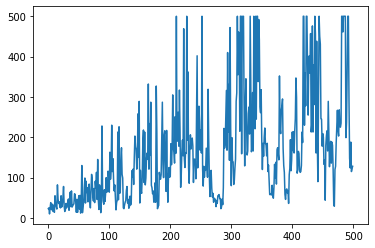

In [69]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []

    def forward(self, x, only_value=False):
        
        # used to compute for the target for the training for A2C
        if only_value:
            with torch.no_grad():
                x = F.relu(self.affine1(x))
                return self.value_head(x)
            
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

policy = Policy()
optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, gamma, init_reward=0):
    R = init_reward
    returns = []
    for r in rewards_arr[::-1]:
        R = r + R*gamma
        returns.insert(0, R)
#     print('rewards_arr', rewards_arr)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def train_on_rollout(gamma=0.99):
    returns = discount_rewards(policy.rewards, gamma)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    
def n_step_train(observation, done, gamma = 0.99):
#     print('1111')
    if done:
        final_value = torch.zeros(0)
    else:
        final_value = torch.from_numpy(observation).float()
        final_value = policy.forward(final_value, only_value=True).item()
    
    R = final_value
    returns = []
    for r in policy.rewards[::-1]:
        if r == 0: R = 0
        R = r + R*gamma
        returns.insert(0, R)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.mse_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.mean(torch.stack(actor_loss)) + torch.mean(torch.stack(critic_loss))
    loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]

def learn_episodic_A2C(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    batch_size_updates = 10
    i = 0
#     dones = deque([], maxlen=batch_sizes_updates)
    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            i += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.rewards.append(reward*(not done))
            total_r += reward
#             dones.append(done)
            if i % 500 == 0:
                n_step_train(observation, done, df)
            if done:
#                 train_on_rollout(0.99)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards

N_EPS= 500
rewards_A2C = learn_episodic_A2C(N_EPS, 500)
plt.plot(rewards_A2C)

### TODO

try to train the model on r + V(x') - V(x) advantage